In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

file_path = r"../../merged data sets/aggregated/aggregated_chicago_dataset_2012plus.csv"

df = pd.read_csv(file_path)
df = df.replace([np.inf, -np.inf], np.nan)
df = df[df["community_area"] != 46].copy()
df = df[df["pop_total"] > 0].copy()

df["is_shooting"] = (df["shooting_count"] > 0).astype(int)

df.head()

,community_area,year,homicide_count,homicide_arrests,homicide_domestic,shooting_count,shooting_arrests,shooting_domestic,pop_total,pop_age_0_17,...,pct_below_poverty,pct_unemployed,pct_without_hs_diploma,per_capita_income,hardship_index,homicide_arrest_rate,shooting_arrest_rate,homicides_per_10k,shootings_per_10k,is_shooting
0,1,2012,6.0,4.0,1.0,165.0,58.0,3.0,50295.0,8007.0,...,23.6,8.7,18.2,23939.0,39.0,0.666667,0.351515,1.192962,32.806442,1
1,1,2013,4.0,1.0,1.0,113.0,36.0,9.0,50295.0,8007.0,...,23.6,8.7,18.2,23939.0,39.0,0.250000,0.318584,0.795308,22.467442,1
2,1,2014,8.0,1.0,0.0,110.0,32.0,4.0,50295.0,8007.0,...,23.6,8.7,18.2,23939.0,39.0,0.125000,0.290909,1.590615,21.870961,1
3,1,2015,6.0,3.0,1.0,100.0,22.0,5.0,50295.0,8007.0,...,23.6,8.7,18.2,23939.0,39.0,0.500000,0.220000,1.192962,19.882692,1
4,1,2016,5.0,3.0,0.0,117.0,27.0,6.0,50295.0,8007.0,...,23.6,8.7,18.2,23939.0,39.0,0.600000,0.230769,0.994135,23.262750,1


In [2]:
features = [
    "shooting_count", "homicide_count",
    "shootings_per_10k", "homicides_per_10k",
    "shooting_domestic", "homicide_domestic",
    "shooting_arrest_rate", "homicide_arrest_rate",
    "pct_below_poverty", "pct_unemployed",
    "pct_without_hs_diploma", "hardship_index"
]

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

weights = {
    "shooting_count": 0.25,
    "homicide_count": 0.25,
    "shootings_per_10k": 0.25,
    "homicides_per_10k": 0.25,
    "shooting_arrest_rate": -0.15,
    "homicide_arrest_rate": -0.15,
    "pct_below_poverty": 0.10,
    "pct_unemployed": 0.10,
    "pct_without_hs_diploma": 0.10,
    "hardship_index": 0.10,
    "shooting_domestic": -0.05,
    "homicide_domestic": -0.05
}

df_scaled["gang_activity_score"] = 0.0
for col, w in weights.items():
    df_scaled["gang_activity_score"] += df_scaled[col] * w

threshold = df_scaled["gang_activity_score"].quantile(0.75)
df_scaled["gang_activity"] = (df_scaled["gang_activity_score"] >= threshold).astype(int)

df_scaled[["gang_activity_score", "gang_activity"]].head()


,gang_activity_score,gang_activity
0,0.012332,0
1,0.060300,0
2,0.106482,0
3,0.044072,0
4,0.033715,0


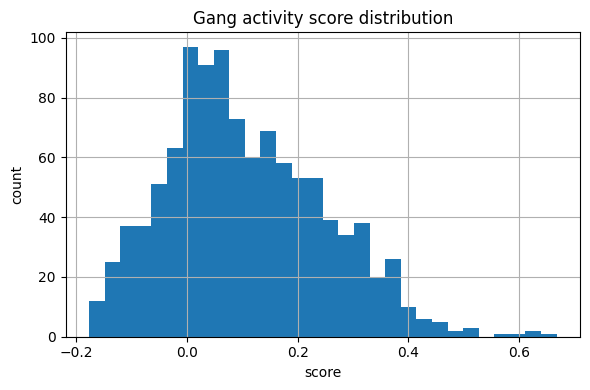

,gang_activity,homicides_per_10k,shootings_per_10k,pct_below_poverty,hardship_index
0,0,0.014939,0.010912,0.261818,0.387355
1,1,0.083270,0.043147,0.595370,0.820557


In [3]:
df_scaled["gang_activity"].value_counts()

plt.figure(figsize=(6,4))
df_scaled["gang_activity_score"].hist(bins=30)
plt.title("Gang activity score distribution")
plt.xlabel("score")
plt.ylabel("count")
plt.tight_layout()
plt.show()

out_path = r"../../merged data sets/aggregated/aggregated_with_gang_indicator.csv"
df_scaled.to_csv(out_path, index=False)

summary = (
    df_scaled.groupby("gang_activity")[
        ["homicides_per_10k", "shootings_per_10k", "pct_below_poverty", "hardship_index"]
    ]
    .mean()
    .reset_index()
)

summary
